## GRUPO 2

#### *Integrantes:* 

1. Diego Alonso Gómez (20171738)
2. Alexander .... (.........)

_____
## Question 1: Orthogonal Learning
_____

1. Replicate Simulation Design 1 three times using different numbers of trials. So you have to use:

- The equation of Y for the three cases now is: Y = 5*D + beta*X + rnorm(n)
- B = 50 , B = 100, B = 1000.
- Explain what do you see in the distribution of the histograms. Where the orthogonal and Naive should be centered?
- Why does this happen? Give an econometric explanation of this.
- Label your axes and legends correctly your figures.

# -----------------------------------------------------------------------------------------------------------

_____
## Question 2: Double Lasso - Testing the Convergence Hypothesis
_____

1. Explain what is the Double Lasso Approach in a markdown cell. Use equations for a better explanation.

2. Replicate the results using the next approaches:
- OLS
- Double LASSO using cross Validation (GLMNET in R and Sklearn in Python )
- Double Lasso using theoretical Lambda (HDM package both in R and Python)
- Double Lasso using method="partialling out", this is a direct way to get results from the HDM package, check the Python script for an example, and also you have to read the documentation for more details.
- Plot the main coefficient and its confidence interval of the convergence hypothesis from these 4 cases in one figure.

## 1.  Explanation of Double Lasso Approach:  (FALTA)

We provide an additional empirical example of partialling-out with Lasso to estimate the regression coefficient $\beta_1$ in the high-dimensional linear regression model:

  $$
  Y = \beta_1 D +  \beta_2'W + \epsilon.
  $$
  
Specifically, we are interested in how different countries' real exchange rate growth rate --i.d real currency depreciation--($Y$) are related to the initial Central Bank policy rate of each country ($D$), controlling for country's inflation, risk premium, and other similar characteristics ($W$).
  
The relationship is captured by $\beta_1$, the *speed of convergence/divergence*, which measures the speed at which poor countries catch up $(\beta_1< 0)$ or fall behind $(\beta_1> 0)$ rich countries, after controlling for $W$. Our inference question here is: do rich countries' real currency depreciation growth slower than poor countries, controlling for the covariates previously mentioned? In other words, is the convergence speed positive: $ \beta_1 > 0?$ 

The outcome $Y$ is the realized annual growth rate of a country's wealth  (Gross Domestic Product per capita). The target regressor ($D$) is the initial level of the country's wealth. The target parameter $\beta_1$ is the speed of convergence, which measures the speed at which poor countries catch up with rich countries. The controls ($W$) include measures of education levels, quality of institutions, trade openness, and political stability in the country.


## 2.  Replicate the results using the next approaches:

In [35]:
library(hdm)
library(xtable)
GrowthData <- GrowthData
save(GrowthData, file = "../data/GrowthData.RData")
library(hdm)
df_growth <- GrowthData
attach(df_growth)
names(df_growth)

# METHOD 1: OLS

In [38]:
reg.ols <- lm(Outcome~.-1,data=df_growth)
summary(reg.ols)


Call:
lm(formula = Outcome ~ . - 1, data = df_growth)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.040338 -0.011298 -0.000863  0.011813  0.043247 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)   
intercept  2.472e-01  7.845e-01   0.315  0.75506   
gdpsh465  -9.378e-03  2.989e-02  -0.314  0.75602   
bmp1l     -6.886e-02  3.253e-02  -2.117  0.04329 * 
freeop     8.007e-02  2.079e-01   0.385  0.70300   
freetar   -4.890e-01  4.182e-01  -1.169  0.25214   
h65       -2.362e+00  8.573e-01  -2.755  0.01019 * 
hm65       7.071e-01  5.231e-01   1.352  0.18729   
hf65       1.693e+00  5.032e-01   3.365  0.00223 **
p65        2.655e-01  1.643e-01   1.616  0.11727   
pm65       1.370e-01  1.512e-01   0.906  0.37284   
pf65      -3.313e-01  1.651e-01  -2.006  0.05458 . 
s65        3.908e-02  1.855e-01   0.211  0.83469   
sm65      -3.067e-02  1.168e-01  -0.263  0.79479   
sf65      -1.799e-01  1.181e-01  -1.523  0.13886   
fert65     6.881e-03  2.705e-02   0.

We determine the regression coefficient $\beta_1$ of the target regressor *gdpsh465* ($D$), its 95% confidence interval and the standard error.

In [69]:
estimator_ols <- summary(reg.ols)$coef["gdpsh465",1]
# output: estimated regression coefficient corresponding to the target regressor

standard_error_ols <- summary(reg.ols)$coef["gdpsh465",2]
# output: std. error

bounds <- confint(reg.ols)[2,]
# output: 95% confidence interval

results_ols <- as.data.frame(cbind(estimator_ols,standard_error_ols,bounds[1],bounds[2]))
colnames(results_ols) <-c("estimator","standard error", "lower bound CI", "upper bound CI")
rownames(results_ols) <-c("OLS")

In [70]:
library(xtable)
table <- matrix(0, 1, 4)
table[1,1:4]   <- c(estimator_ols,standard_error_ols,bounds[1],bounds[2])
colnames(table) <-c("estimator","standard error", "lower bound CI", "upper bound CI")
rownames(table) <-c("OLS")
tab1<- xtable(table, digits = 3) 

<!-- html table generated in R 3.6.3 by xtable 1.8-4 package -->
<!-- Tue Jan 19 10:23:32 2021 -->
<table border=1>
<tr> <th>  </th> <th> estimator </th> <th> standard error </th> <th> lower bound CI </th> <th> upper bound CI </th>  </tr>
  <tr> <td align="right"> OLS </td> <td align="right"> -0.009 </td> <td align="right"> 0.030 </td> <td align="right"> -0.071 </td> <td align="right"> 0.052 </td> </tr>
   </table>

Least squares provides a rather noisy estimate (high standard error) of the speed of convergence, and does not allow us to answer the question about the convergence hypothesis since the confidence interval includes zero.

In contrast, we can use the partialling-out approach based on lasso regression ("Double Lasso").

# Method 2 - Double LASSO using cross Validation (GLMNET) 

In [44]:
A <- as.matrix(df_growth)[, 1, drop = F] # output variable
X <- as.matrix(df_growth)[, -c(1, 2,3)] # controls
Z <- as.matrix(df_growth)[, 3, drop = F] # target regressor
dim(X)
dim(A)
dim(Z)

[1] 90 60

[1] 90  1

[1] 90  1

In [45]:
library(glmnet)
fit.lasso.cv  <- cv.glmnet(x=X,y=A, family="gaussian", alpha=1)
yhat.lasso.cv <- predict(fit.lasso.cv,newx=X)
r.A <- A-yhat.lasso.cv # creates the "residual" output variable

fit.lasso.cv  <- cv.glmnet(x=X,y=Z, family="gaussian", alpha=1)
yhat.lasso.cv <- predict(fit.lasso.cv,newx=X)
r.Z <- A-yhat.lasso.cv  # creates the "residual" target regressor

partial.lasso <- lm(r.A ~ r.Z)
est_lasso <- partial.lasso$coef[2]
std_lasso <- summary(partial.lasso)$coef[2,2]
ci_lasso <- confint(partial.lasso)[2,]


In [68]:
library(xtable)
table <- matrix(0, 1, 4)
table[1,1:4]   <- c(est_lasso,std_lasso,ci_lasso[1],ci_lasso[2])
colnames(table) <-c("estimator","standard error", "lower bound CI", "upper bound CI")
rownames(table) <-c("LASSO - GLMNET")
tab2<- xtable(table, digits = 3)
tab2

,estimator,standard error,lower bound CI,upper bound CI
,<dbl>,<dbl>,<dbl>,<dbl>
LASSO - GLMNET,-0.04981147,0.01393636,-0.07750705,-0.02211588


# Method 3 - Double Lasso using theoretical Lambda (HDM)

We can use the partialling-out approach based on lasso regression ("Double Lasso")

In [47]:
Q <- df_growth[, 1, drop = F] # output variable
K <- as.matrix(df_growth)[, -c(1, 2,3)] # controls
B <- df_growth[, 3, drop = F] # target regressor
dim(K)
dim(Q)
dim(B)

[1] 90 60

[1] 90  1

[1] 90  1

In [48]:
r.Q <- rlasso(x=K,y=Q)$res # creates the "residual" output variable
r.B <- rlasso(x=K,y=B)$res # creates the "residual" target regressor
partial.lasso <- lm(r.Q ~ r.B)
est_lasso <- partial.lasso$coef[2]
std_lasso <- summary(partial.lasso)$coef[2,2]
ci_lasso <- confint(partial.lasso)[2,]

In [66]:
library(xtable)
table <- matrix(0, 1, 4)
table[1,1:4]   <- c(est_lasso,std_lasso,ci_lasso[1],ci_lasso[2])
colnames(table) <-c("estimator","standard error", "lower bound CI", "upper bound CI")
rownames(table) <-c("LASSO - HBM")
tab3<- xtable(table, digits = 3)
tab3

,estimator,standard error,lower bound CI,upper bound CI
,<dbl>,<dbl>,<dbl>,<dbl>
LASSO - HBM,-0.04981147,0.01393636,-0.07750705,-0.02211588


# Method 4 - Double Lasso using method="partialling out"

In [55]:
O <- df_growth[, 1, drop = F] # output variable
R <- as.matrix(df_growth)[, -c(1, 2,3)] # controls
J <- df_growth[, 3, drop = F] # target regressor

In [56]:
lasso_direct = rlassoEffect(x = R, y = O, d = J, method = "partialling out")
names(lasso_direct)

[1] "alpha"            "se"               "t"                "pval"            
 [5] "coefficients"     "coefficient"      "coefficients.reg" "selection.index" 
 [9] "residuals"        "call"             "samplesize"

In [57]:
est_lasso = lasso_direct$coefficients
std_lasso = lasso_direct$se
lower_ci_lasso = est_lasso - 1.96*std_lasso
upper_ci_lasso = est_lasso + 1.96*std_lasso

In [67]:
library(xtable)
table <- matrix(0, 1, 4)
table[1,1:4]   <- c(est_lasso,std_lasso,ci_lasso[1],ci_lasso[2])
colnames(table) <-c("estimator","standard error", "lower bound CI", "upper bound CI")
rownames(table) <-c("LASSO - PARTIALLING OUT")
tab4<- xtable(table, digits = 3)
tab4

,estimator,standard error,lower bound CI,upper bound CI
,<dbl>,<dbl>,<dbl>,<dbl>
LASSO - PARTIALLING OUT,-0.04981147,0.01393636,-0.07750705,-0.02211588


# Plot the main coefficient and its confidence interval

Finally, let us have a look at the results.

In [25]:
Table_Final=rbind(tab1,tab2,tab3,tab4)
Table_Final

,estimator,standard error,lower bound CI,upper bound CI
,<dbl>,<dbl>,<dbl>,<dbl>
OLS,-0.009377989,0.029887726,-0.070600221,0.05184424
LASSO - GLMNET,0.003739563,0.005887944,-0.007961487,0.01544061
LASSO - HDM,-0.049811465,0.013936358,-0.077507049,-0.02211588
LASSO - PARTIALLING OUT,-0.049811465,0.013936358,-0.077507049,-0.02211588


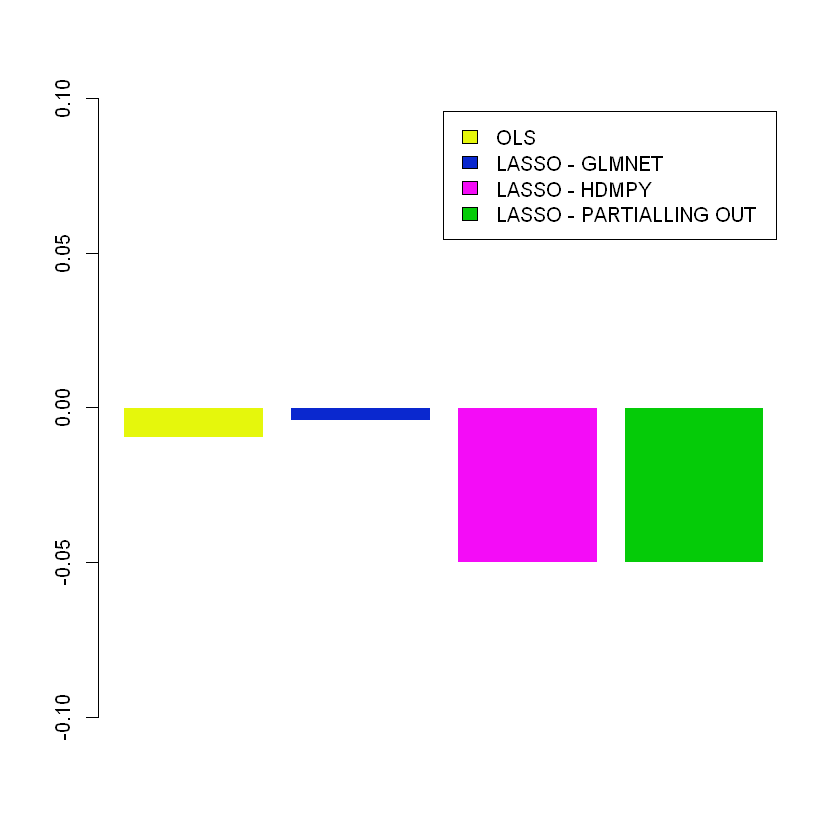

In [65]:
Base=data.frame(Metodo=c("OLS","LASSO - GLMNET","LASSO - HDMPY","LASSO - PARTIALLING OUT"), 
     Estimador=c(tab1$estimator,tab2$estimator,tab3$estimator,tab4$estimator))

barplot(Base$Estimador,col=c("#e5f70c","#0a28cf","#f40cf7","#05cb08"),ylim=c(-0.1,0.1),legend.text=Base$Metodo, border='white')